In [147]:
import pandas as pd
import datetime
import math

In [148]:
from understanding_data import seller_monthly_transaction_count_line_graph
from understanding_data import seller_biweekly_transaction_count_line_graph

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [150]:
def getInformation(s_id):
    sellerdf, unique_prod_categories = getData(s_id)
    print('Unique Product Categories Sold by Seller:', unique_prod_categories)
    startdate = sellerdf['order_purchase_timestamp'].min()
    enddate = sellerdf['order_purchase_timestamp'].max()
    print('Earliest Sale Date:', startdate)
    print('Last Sale Date:',enddate)
    print('\n Basic Information on sales by seller:\n')
    dataseller = sellerdf['product_category_name_english'].value_counts()
    dataseller_df = pd.DataFrame(data=dataseller)
    dataseller_df.rename(columns={'product_category_name_english':'sales per product category'},inplace=True)
    print(dataseller_df)

def getDashboard(s_id):
    sellerdf, unique_prod_categories = getData(s_id)
    prod_select = input('Enter Product Category:')
    print('Monthly Sales of Category:',prod_select)
    seller_monthly_transaction_count_line_graph(s_id, prod_select)
    print('Bi Weekly Sales of Product Category:', prod_select)
    seller_biweekly_transaction_count_line_graph(s_id, prod_select)

def getData(s_id):
    data_new = pd.read_csv('../Data/Primary_Secondary.csv')
    data_new = data_new.drop(columns = ['Unnamed: 0'])
    data_new['order_purchase_timestamp'] = pd.to_datetime(data_new['order_purchase_timestamp'])
    new_data = data_new[data_new.seller_id==s_id]
    new_data = new_data.sort_values(by='order_purchase_timestamp')
    new_data = new_data.drop(['order_id', 'customer_id', 'order_status',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'shipping_limit_date',
       'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_name_lenght', 'product_description_lenght',
       'customer_unique_id','Bi-Weekly','datediff_purchase_deliver'],axis=1)
    unique = new_data['product_category_name_english'].unique()
    return new_data, unique

In [158]:
def Gradient_Boosting_Model(seller_id):
    model_data,unique_names = getData(seller_id)
    
    category = input('Enter Product Category you want to analyze:')
    model_data = model_data[model_data['product_category_name_english']==category]
    
    #Extract date from order_purchase_timestamp
    model_data['order_purchase_timestamp'] = model_data['order_purchase_timestamp'].apply(lambda x: x.date()).astype('str')
    model_data = model_data.drop(['seller_id','product_category_name_english','customer_city','customer_state'],axis=1)
    
    ## Count the number sales on each day
    seller_count = model_data.groupby(['order_purchase_timestamp']).size().reset_index(name='count')
    model_data = pd.merge(model_data, seller_count, how='inner',left_on=['order_purchase_timestamp'],right_on=['order_purchase_timestamp'])
    model_data = model_data.drop_duplicates(keep='first',subset = 'order_purchase_timestamp')
    
    
    ## Perform train test split. We are taking last 30 days from data for testing. Remaining is used for training
    length = model_data.shape[0]
    num_rows_split = length - 30 
    model_data = model_data.drop(['order_purchase_timestamp','transaction_year','transaction_date'],axis = 1)
    model_train = model_data[:num_rows_split]
    model_test = model_data[num_rows_split:]
    
    x_train = model_train.drop(columns = 'count',axis = 1)
    y_train = model_train['count']

    x_test = model_test.drop(columns = 'count',axis = 1)
    y_test = model_test['count']

    
    params = {'n_estimators': 200, 'min_samples_split': 3,'learning_rate': 0.1, 'loss': 'ls','verbose':1}
    clf = ensemble.GradientBoostingRegressor()
    clf.fit(x_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(x_test))
    print("MSE: %.4f" % mse)


    test_score = np.zeros((100,), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_predict(x_test)):
        test_score[i] = clf.loss_(y_test, y_pred)

    ## Plotting training and testing deviance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(100) + 1, clf.train_score_, 'b-',label='Training Set Deviance')
    plt.plot(np.arange(100) + 1, test_score, 'r-',label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    plt.show()
    y_pred1 = clf.staged_predict(x_train)

    feature_importance = clf.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    fig = plt.gcf()
    fig.set_size_inches(12.5,8.5)
    plt.plot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    fiveday_actual = []
    fiveday_pred = []
    for i in range(6):
        fiveday_actual.append(math.ceil(sum(y_test[5*i:5*i+5])))
        fiveday_pred.append(math.ceil(sum(clf.predict(x_test)[5*i:5*i+5])))
    
    agg_pred = math.ceil(sum(clf.predict(x_test)))
    agg_actual = math.ceil(sum(y_test))
    print("Actual count",agg_actual)
    print("Predicted count",agg_pred)
    
    plt.plot(fiveday_actual)
    plt.plot(fiveday_pred,'r')
    plt.show()

Enter Product Category you want to analyze:watches_gifts
MSE: 15.1993


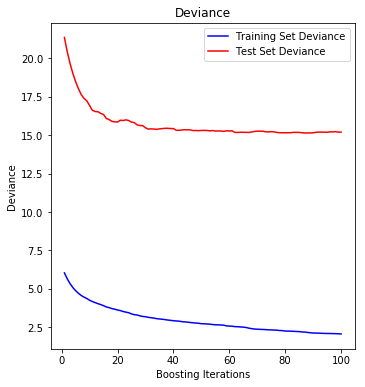

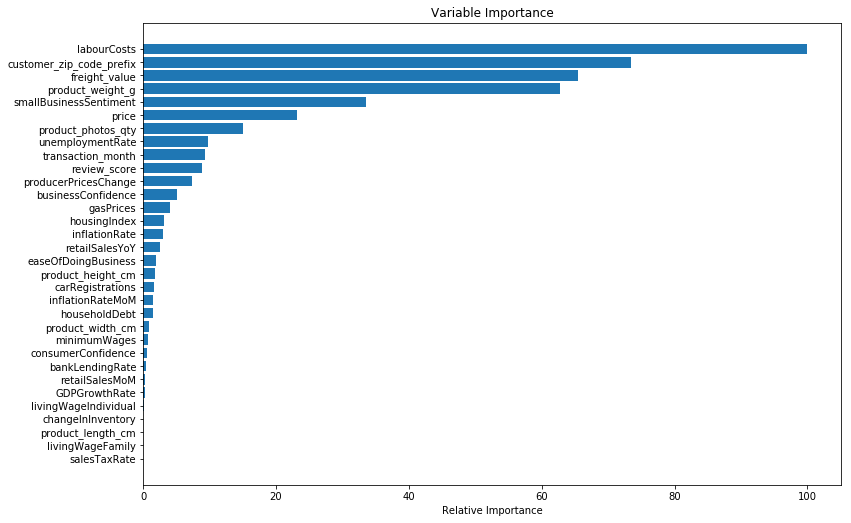

Actual count 182
Predicted count 174


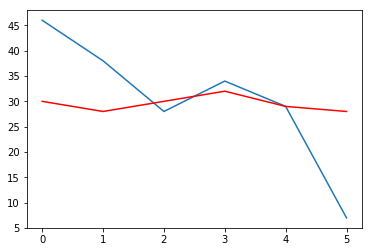

In [160]:
Gradient_Boosting_Model('6560211a19b47992c3666cc44a7e94c0')

## This is found to be the best model of all that we have tried.
## Type garden_tools when asked for category

Enter Product Category you want to analyze:watches_gifts
MSE: 14.8381


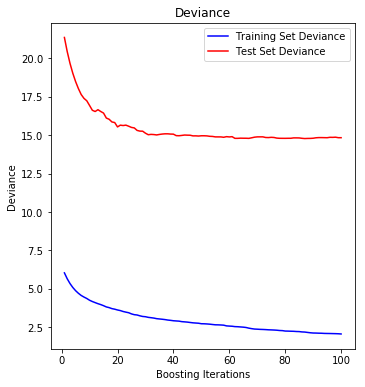

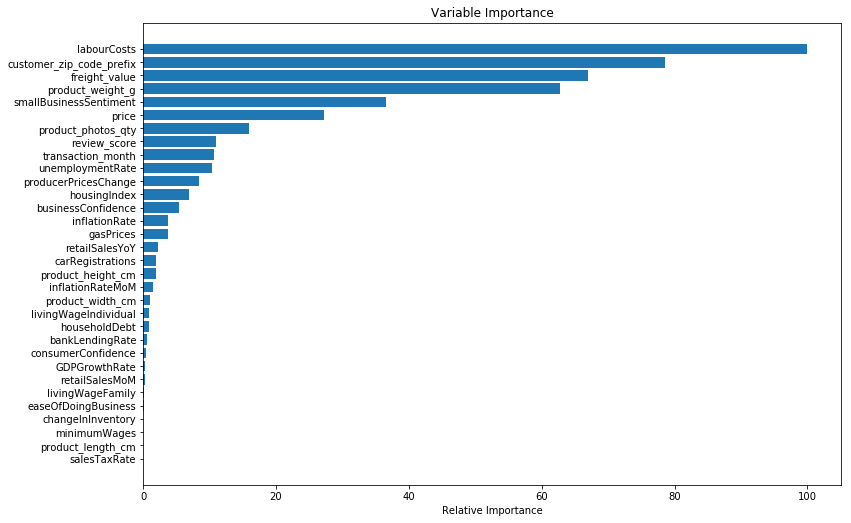

Actual count 182
Predicted count 172


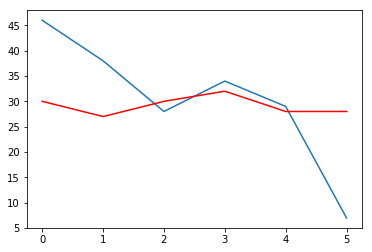

In [161]:
Gradient_Boosting_Model('6560211a19b47992c3666cc44a7e94c0')
## This doesn't perform well and the prediction is way off for this model. We'll probably need to build a separate model for such cases

## Enter watches_gifts when asked for category

In [155]:
from fbprophet import Prophet

In [156]:
def prophet_model(seller_id):
    model_data,unique_names = getData(seller_id)
    
    category = input('Enter Product Category you want to analyze:')
    model_data = model_data[model_data['product_category_name_english']==category]
    
    ## Extract date from order_purchase_timestamp
    model_data['order_purchase_timestamp'] = model_data['order_purchase_timestamp'].apply(lambda x: x.date()).astype('str')
    model_data['order_purchase_timestamp'] = pd.to_datetime(model_data['order_purchase_timestamp'])
    
    seller_count = model_data.groupby(['order_purchase_timestamp']).size().reset_index(name='count')
    model_data = pd.merge(model_data, seller_count, how='right',left_on=['order_purchase_timestamp'],right_on=['order_purchase_timestamp'],copy=False)

    model_data = model_data.drop_duplicates(keep='first',subset = 'order_purchase_timestamp')
    
    seller = model_data[['order_purchase_timestamp','count']]
    seller.columns  = ['ds','y']
    
    
    ## Split into train and test based on last 30 
    train = seller[:-30]
    test = seller[-30:]
    
    end = test['ds'].iloc[-1]
    start = test['ds'].iloc[0]
    diff = end -start
    
    ## Add holidays of interest for better prediction during this time
    holidays = pd.DataFrame({'holiday': 'days_of_interest','ds': pd.to_datetime(['2017-01-01','2017-02-27','2017-02-28',
    '2017-03-01','2017-04-14','2017-04-21','2017-05-01','2017-05-15','2017-07-09','2017-09-07','2017-10-12','2017-10-27',
    '2017-11-01','2017-11-02','2017-11-15','2017-11-20','2017-12-25','2018-01-01','2018-02-27','2018-02-28',
    '2018-03-01','2018-04-14','2018-04-21','2018-05-01','2018-05-15','2018-07-09']),
  'lower_window': -1,
  'upper_window': 1,
})
    prophet_model = Prophet(changepoint_prior_scale=0.5,weekly_seasonality=True,holidays=holidays)
    
    prophet_model.fit(train)
    
    
    ## set the extended periods as present in the test data
    predict = prophet_model.make_future_dataframe(periods=diff.days)
    
    forecast = prophet_model.predict(predict)
    
    forecast_tail = forecast[['ds','yhat','yhat_lower','yhat_upper']]
    
    ## plot the prophet forecasts
    fig1 = prophet_model.plot(forecast)
    
    fig2 = prophet_model.plot_components(forecast)
    
    ## Count extra number of days in training 
    diff_train = (train['ds'].iloc[-1] - train['ds'].iloc[0]).days
    
    extra_days_test = math.floor(((diff_train-train.shape[0])/train.shape[0])*30)    
    ## Predicted Count on the test
    predicted_count  = np.ceil(np.sum(forecast_tail[-diff.days:]['yhat']))
    
    ## Average number of sales predicted per day
    average = math.floor(train['y'].median())
    
    
    ## Remove the extra count values coming from extra days
    predicted_count = predicted_count - extra_days_test*average
    
    ## Actual count of the test set
    actual_count = np.sum(test['y'])
    
    print("Predicted count = ",predicted_count)
    print("Average Sales = ",average)
    print("Actual count = ",actual_count)

Enter Product Category you want to analyze:watches_gifts


C:\Users\user\Anaconda3\envs\fb_prophet\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\user\Anaconda3\envs\fb_prophet\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Predicted count =  179.0
Average Sales =  3
Actual count =  182


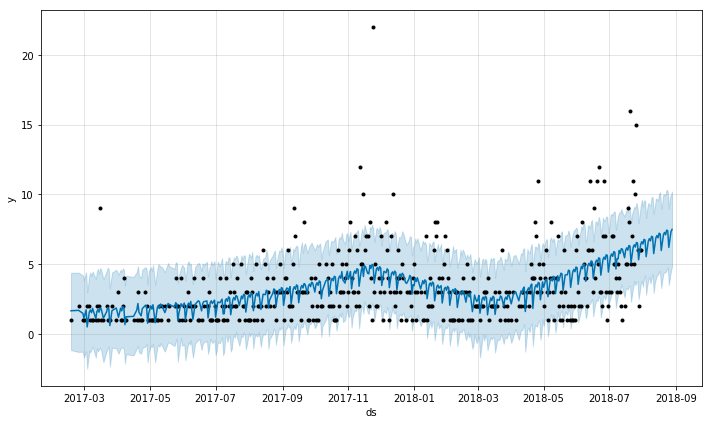

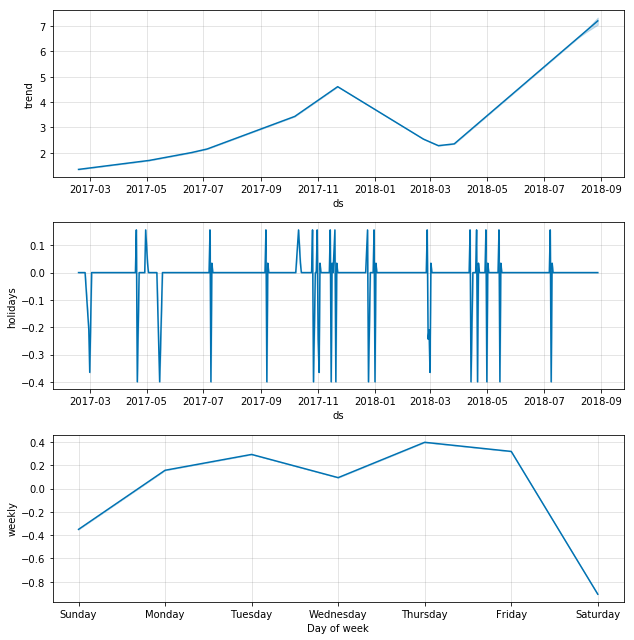

In [163]:
prophet_model('6560211a19b47992c3666cc44a7e94c0')